# Calibration

Modern integrated circuits, or chips, are manufactured using a complex process where the chips are essentially printed onto a silicon wafer (see this **[video](https://www.youtube.com/watch?v=g8Qav3vIv9s)** for an overview of the process). Each wafer contains many chips (e.g. a wafer with 300mm diameter fits several hundred laptop grade microprocessors). The chips on a finished wafer are tested to identify which are good and which are faulty. The yield of a wafer is determined by the fraction of good chips. To maximize the yield, semiconductor manufacturers are interested in identifying and correcting the causes of the faulty chips (e.g. wrong settings in one of processing steps). Some causes can be identified by visual inspection of patterns in a wafer maps, showing which chips are good and which are faulty.

![wafer.png](attachment:wafer.png)

In this assignment you will work with wafer map data from a semiconductor manufacturing process. Your task will be to develop a calibrated classifier for identifying patterns of faulty chips on a finished wafer. Identifying such patterns can help with optimizing the manufacturing process parameters for the following wafers.

#### Deliverable

Throughout this notebook you will find cells starting with `#TODO` and `# // BEGIN_TODO`.

- Fill in all these TODO cells. The `#TODO` cells are meant to guide you (you are strongly encouraged to fill these in!), while the `#BEGIN_TODO` _answer cells_ will be graded.
- Answer cells start and end with tags, `# // BEGIN_TODO [Q0]` and `# // END_TODO [Q0]`, for example. Do not edit these tags in any way, or else your answers may not be processed by the grading system.
- Be careful when importing additional libraries. The code for of your answers will be evaluated automatically and we cannot guarantee that any additional libraries will be available in that environment. Please check the Momotor output on Canvas after submitting the assignment, you should be able to see if all your code executed without errors. If in doubt, please ask your instructor.
- You can add arbitrary many code and text cells between the `# // BEGIN_TODO` and `# // END_TODO` tags to make your code nicely readable.

You are encouraged to play with the data and extend this notebook in order to obtain your answers. You may insert cells at any point in the notebook, but remember:
<br/><br/>
<div style="padding: 15px; border: 1px solid transparent; border-color: transparent; margin-bottom: 20px; border-radius: 4px; color: #a94442; background-color: #f2dede; border-color: #ebccd1;
">
Only the code in your answer cells (i.e. between `# // BEGIN_TODO` and `# // END_TODO`) will be extracted and evaluated.
</div>

At the end, deliver the filled in **and executed** `.ipynb` file by submitting it to the corresponding assignment on Canvas. You may submit as many times as you like before the deadline. The last submission counts.

> **IMPORTANT:** Before delivering your notebook, make sure that the cells in your notebook can be executed in sequence without errors, by executing "Restart & Run All" from the "Kernel" menu.

Let's get started by filling in your details in the following answer cell. Assign your group number, your names and student ids to variables `group_number`, `name_student1`, `id_student1`, `name_student2`, `id_student2`, e.g.:

```
# // BEGIN_TODO [AUTHOR]
group_number = "7"
name_student1 = "John Smith"
id_student1 = "1234567"
name_student2 = "Jane Miller"
id_student2 = "7654321"
# // END_TODO [AUTHOR]
```

In [1]:
#// BEGIN_TODO [AUTHOR]

group_number = "4"
name_student1 = "Silvia Sultana"
id_student1 = "1594214"
name_student2 = "Srinidhi Ilango"
id_student2 = "1727141"

#// END_TODO [AUTHOR]

## Import libraries

Later, the code in your answer cells will be evaluated in an environment with several typical data science libraries installed, including pandas, numpy, matplotlib, sklearn. You are free to use them. If you would like to use other libraries, please contact the instructor to see if it can be accommodated. Please import any additional libraries inside your answer cells (otherwise your code may crash during evaluation).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

## Load the data

The data resides in the `./data/wafer_calibration.pkl` pickle file. It is based on the WM-811K dataset containing annotated wafer maps collected from real-world fabrication (see `./data/readme.txt`).

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
with open('/content/drive/MyDrive/calibration/data/wafer.pkl', 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

`X` contains wafer maps and `y` contains the labels. The maps are 26x26 pixels, a pixel of value 0 represents the background, a pixel of value 1 indicates a good chip, and a pixel of value 2 indicates a bad chip. An example of a wafer map is shown below.

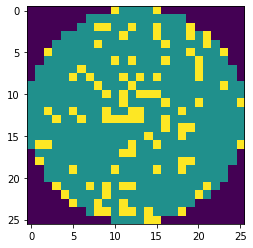

In [5]:
plt.imshow(X_train[0]);

The wafer maps were labeled by human experts according to bad chip patterns, where each label is an integer:

- 0: No pattern
- 1: Center
- 2: Donut
- 3: Edge-local
- 4: Edge-ring
- 5: Local
- 6: Near-full
- 7: Random
- 8: Scratch

An example of the wafer map for each pattern is shown below. Note that not all patterns may be present in this particular data set. 

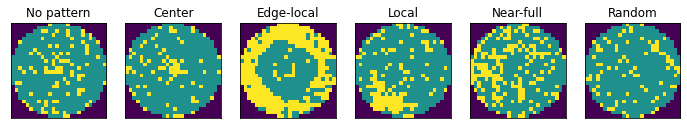

In [6]:
unique_classes, class_indexes = np.unique(y_train,return_index=True)
class_names = ["No pattern", "Center", "Donut", "Edge-local", "Edge-ring", "Local", "Near-full", "Random", "Scratch"]
fig, axes = plt.subplots(1,len(unique_classes), figsize = (12,5))
for num_index, index in enumerate(class_indexes):
    axes[num_index].imshow(X_train[index])
    axes[num_index].set_title(class_names[unique_classes[num_index]])
    axes[num_index].set_xticks([])
    axes[num_index].set_yticks([])

## Train a classifier

In this part you will implement a classifier, which will be used later for evaluating your calibration method.

First, start by exploring the data. Remember, you can add as many code and markdown cells as you like.

In [7]:
# TODO: Explore the data
print(f"Shape: {X_train.shape}")
print(f"Non-zero vs zero: {np.count_nonzero(y_train), np.count_nonzero(y_train==0)}")

Shape: (4310, 26, 26)
Non-zero vs zero: (431, 3879)


In the first part of this assignment the aim is to identify whether the wafer map contains any known patterns or not. We therefore treat it as a binary classification problem and replace labels other than 0 to 1.

In [8]:
y_binary_train = np.copy(y_train)
y_binary_train[y_binary_train != 0] = 1

y_binary_test = np.copy(y_test)
y_binary_test[y_binary_test != 0] = 1

In [9]:
len(y_binary_test[y_binary_test==0]),len(y_binary_test[y_binary_test!=0])

(1792, 198)

In [10]:
#creating a validation set from the train set itself

from sklearn.model_selection import train_test_split

X_train, X_val, y_binary_train, y_binary_val = train_test_split(X_train, y_binary_train, test_size = 0.1, random_state =42)


In [11]:
print(f'The shape of the validation data is {X_val.shape}') 
print(f'The shape of the validation labels is {y_binary_val.shape}')
print(f'The shape of a wafer image in validation dataset is {X_val[0].shape}')
print(f'The shape of the new train data is {X_train.shape}')

The shape of the validation data is (431, 26, 26)
The shape of the validation labels is (431,)
The shape of a wafer image in validation dataset is (26, 26)
The shape of the new train data is (3879, 26, 26)


#### Step 1

Choose a metric for evaluating the classifier's generalization performance and assign your choice to a string variable `classifier_metric_choice`. Motivate the choice (including the hyper-parameters, if any) in a string variable `classifier_metric_motivation` (max 800 characters). Describe how you decide based on this metric if a classifier is sufficiently calibrated in a string variable `classifier_metric_decision` (max 200 characters).

In [12]:
#// BEGIN_TODO [STEP_1] Choose a classifier metric (5 points)
classifier_metric_choice = ""

classifier_metric_motivation = ""

classifier_metric_decision = ""

`#TODO`: things to address: class imbalance - task is to detect presence of known pattern. We assume it is important to detect faulty chips, i.e. false positives are fine but false negatives are not (classifying defective chip as non-defective is expensive). Therefore, we choose Recall which is TPR. - Explain c and gamma (used Grid search), balanced classifier since there is class imbalance.

In [13]:
#// END_TODO [STEP_1]

#### Step 2

Train a binary classifier on the training set `X_train` and `y_train`. You are free to chose any model and data preprocessing method, as long as:

- your classifier outputs the predicted class (0 or 1) and the confidence estimate of the positive class,
- your submission executes within 10 minutes on Momotor,
- you use the libraries available on Momotor (if you would like to use other libraries, please contact the instructor to see if it can be accommodated).

Evaluate your trained model on the test set `X_test` and `y_test`. What do you observe? How do you know that your model is well trained? Assign your answer to a string variable `observation_classifier` (max 600 characters).

Apply the classifier to the `X_test` data and store the predicted classes and confidence estimate in the variables `uncalibrated_y` and `uncalibrated_p`, respectively:

- `uncalibrated_y` should be a `np.ndarray` of shape $[N,]$ and `dtype` of `np.int32`, where $N$ is the number of samples and each value is the predicted class,
- `uncalibrated_p` should be a `np.ndarray` of shape $[N,]$ and `dtype` of `np.float32`, where each value is the classifier's confidence in the positive class.

In [14]:
#// BEGIN_TODO [STEP_2] Train a binary classifier (10 points)
from sklearn.svm import SVC

def preprocess(arr):
    arr = arr.reshape(len(arr), -1)
    arr = arr/2
    return arr

c= 100
gamma = 0.001

#TODO: make pipelie of the following steps later
preprocess_arr = preprocess(X_train)

In [15]:
clf = SVC(kernel='rbf',gamma = gamma, C = c, class_weight = 'balanced', probability=True)

clf.fit(preprocess_arr, y_binary_train)

SVC(C=100, class_weight='balanced', gamma=0.001, probability=True)

In [16]:
# predicted label on test set in specific format
uncalibrated_y = clf.predict(preprocess(X_test))
uncalibrated_y = uncalibrated_y.astype('int32')
uncalibrated_y.shape, uncalibrated_y.dtype

((1990,), dtype('int32'))

In [17]:
# predicted confidence (probablity estimate)
preds = clf.predict_proba(preprocess(X_test))

In [18]:
# assuming positive class to be 1
uncalibrated_p = preds[:,1]
uncalibrated_p = uncalibrated_p.astype('float32')

uncalibrated_p.shape, uncalibrated_p.dtype

((1990,), dtype('float32'))

In [19]:
# TODO: interpret the model performance in the below variable
observation_classifier = ""

In [20]:

#predicted probabilities on valid set

preds_valid=clf.predict_proba(preprocess(X_val))
uncalibrated_p_valid = preds_valid[:,1]
uncalibrated_p_valid = uncalibrated_p_valid.astype('float32')

#predicted class values
uncalibrated_y_valid = clf.predict(preprocess(X_val))
uncalibrated_y_valid = uncalibrated_y_valid.astype('int32')


The precision score for validation and test data are 0.34 and 0.38 respectively.
The recall score  for validation and test data are 0.53 and 0.68 respectively.
The F1-score  for validation and test data are 0.42 and 0.49 respectively.


The confusion matrix for binary test data :


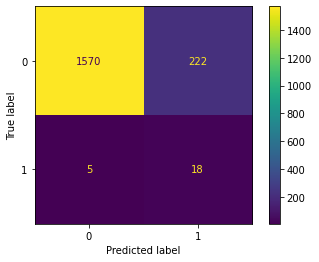



The confusion matrix for binary validation data :


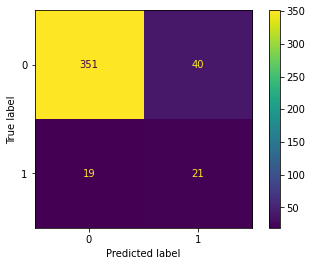

In [21]:
#Evaluating the base classifier SVM's using metrics : Precision, Recall, F1-score, Confusion Matrix

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix,ConfusionMatrixDisplay


precision_val = precision_score(y_binary_val, uncalibrated_y_valid)
precision_test = precision_score(y_binary_test, uncalibrated_y)


recall_val = recall_score(y_binary_val, uncalibrated_y_valid)
recall_test = recall_score(y_binary_test, uncalibrated_y)


f1_val= f1_score(y_binary_val, uncalibrated_y_valid)
f1_test= f1_score(y_binary_test,uncalibrated_y)


print(f'The precision score for validation and test data are {precision_val:.2f} and {precision_test:.2f} respectively.')
print(f'The recall score  for validation and test data are {recall_val:.2f} and {recall_test:.2f} respectively.')
print(f'The F1-score  for validation and test data are {f1_val:.2f} and {f1_test:.2f} respectively.')
print('\n')
print('The confusion matrix for binary test data :')
cm = confusion_matrix(y_test, uncalibrated_y, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

print('\n')
print('The confusion matrix for binary validation data :')
cm_val = confusion_matrix(y_binary_val, uncalibrated_y_valid, labels=clf.classes_)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val,display_labels=clf.classes_)
disp_val.plot()
plt.show()


In [22]:
#// END_TODO [STEP_2]

## Measure and visualize calibration

#### Step 3

Visualize the calibration of your trained model using a reliability diagram. Describe your observations in the variable `observation_uncalibrated` (max 1000 characters).

True Probability of example sample : 0.10062893081761007
Predicted Probability of example sample: 0.13829177540709386
SVM Predicted Probability of example sample: 0.12458857148885727


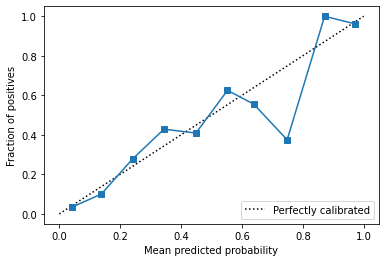

In [23]:
#// BEGIN_TODO [STEP_3] Visualize calibration of uncalibrated model (5 points)

from sklearn.calibration import calibration_curve, CalibrationDisplay


prob_true, prob_pred = calibration_curve(y_binary_test,uncalibrated_p, n_bins=10)
print(f'True Probability of example sample : {prob_true[1]}')
print(f'Predicted Probability of example sample: {prob_pred[1]}')
print(f'SVM Predicted Probability of example sample: {uncalibrated_p[1]}')
disp = CalibrationDisplay(prob_true, prob_pred,uncalibrated_p )
disp.plot()

In [24]:
observation_uncalibrated = ""

In [25]:
#// END_TODO [STEP_3]

#### Step 4

Choose a calibration metric and assign its name to a string variable `binary_metric_choice`. Motivate the choice (including the hyper-parameters, if any) in a string variable `binary_metric_motivation` (max 800 characters). Describe how you decide based on this metric if a classifier is sufficiently calibrated in a string variable `binary_metric_decision` (max 200 characters).

In [44]:
#// BEGIN_TODO [STEP_4] Choose a calibration metric (5 points)

binary_metric_choice = "ECE"

binary_metric_motivation = ""

binary_metric_decision = ""

In [27]:
#// END_TODO [STEP_4]


#### Step 5

Implement the chosen calibration metric. It should be a Python class with the following method:

- `score(self, p, y)`, where
    - `p` is an `np.ndarray` of shape $[N,]$ with the confidence estimates of the *positive class* for $N$ samples.
    - `y` is an `np.ndarray` of shape $[N,]$ with the corresponding true labels (0 or 1).
    - It returns a `np.float` number with the calibration error.

Instantiate the class (setting any relevant hyper-parameters) and assign it to the variable `binary_metric`.

Measure the calibration error of your model on `X_test` and `y_test` and assign the result to the variable `binary_uncalibrated`.

In [38]:
#// BEGIN_TODO [STEP_5] Implement the calibration metric (5 points)

class ECE:

    def score(self, p, y):
        n_bins = 10
        N = len(uncalibrated_p)
        sorted_index_p = np.argsort(p)
        index_bins = np.array_split(sorted_index_p, n_bins)
        ece = 0.0
        
        for bm in index_bins:
            bin_len = len(bm)
            bin_conf = np.take(p, bm).mean()
            bin_frac = np.take(y, bm).mean()
            ece +=  bin_len/N * (np.absolute(bin_frac - bin_conf))
        
        return ece

binary_metric = ECE()
binary_uncalibrated = binary_metric.score(uncalibrated_p, y_binary_test)
binary_uncalibrated

0.016507552302999415

https://github.com/sirius8050/Expected-Calibration-Error/blob/master/ECE.py

In [29]:
# len(np.array_split(uncalibrated_p))
import math
N = len(uncalibrated_p)

sorted_index_p = np.argsort(uncalibrated_p)
index_bins = np.array_split(sorted_index_p, 100)
# (np.take(y_binary_test, index_bins[0]).mean()**2 - np.take(uncalibrated_p, index_bins[0]).mean()**2)
bin_len = len(index_bins[0])
bin_conf = np.take(uncalibrated_p, index_bins[0]).mean()
bin_frac = np.take(y_binary_test, index_bins[0]).mean()

bin_len/N * np.absolute(bin_frac - bin_conf)

4.737144195704005e-05

In [30]:
N = len(uncalibrated_p)

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binned_statistic.html 

sorted_index_p = np.argsort(uncalibrated_p)
index_bins = np.array_split(sorted_index_p, 100)
ece = 0.0
for bm in index_bins:
    bin_len = len(bm)
    bin_conf = np.take(uncalibrated_p, bm).mean()
    bin_frac = np.take(y_binary_test, bm).mean()
    ece +=  bin_len/N * (np.absolute(bin_frac - bin_conf))**2

print(ece**0.5), type(ece)

0.05583937771398296


(None, numpy.float64)

In [31]:
#// END_TODO [STEP_5]

## Calibrate the classifer

#### Step 6

Implement at least two calibration methods. Each calibration method should be a Python class with the following methods:

- `fit(self, p, y)`, where 
    - `p` is an `np.ndarray` of shape $[N,]$ with the confidence estimates of the *positive class* for $N$ samples.
    - `y` is an `np.ndarray` of shape $[N,]$ with the corresponding true labels (0 or 1).
    - It fits the calibration model and returns a reference to `self`.
- `predict_proba(self, p)`, where
    - `p` is an `np.ndarray` of shape $[N,]$ with confidence estimates of the *positive class* for $N$ samples.
    - It returns an `np.ndarray` of shape $[N,]$ with the calibrated confidence estimates for each sample in `p`.

> **IMPORTANT:** You are not allowed to use the `sklearn.calibration.CalibratedClassifierCV()` method.

Instantiate the calibration methods (setting any relevant hyper-parameters) and assign them to a list variable `binary_calibrators`.

In [32]:
#// BEGIN_TODO [STEP_6] Implement calibration methods (10 points)

from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model._glm.glm import BaseEstimator
from sklearn.linear_model import LogisticRegression

#Isotonic Calibrator

class IR_calibrator:

  def fit(self,p,y):
    self.ir_calibrator = IsotonicRegression(out_of_bounds = 'clip').fit(p,y)
    return self
  
  def predict_proba(self,p):
    conf_est = self.ir_calibrator.transform(p)
    return conf_est



#Platt Scaling 

class PlattCalibrator(BaseEstimator):
  def __init__(self,c:int=1e10):
    self.c=c
  
  def fit(self,p:np.ndarray, y :np.ndarray):
    logistic=LogisticRegression(C=self.c,solver='lbfgs')
    logistic.fit(p.reshape(-1,1),y)
    self.coef_=logistic.coef_[0]
    self.intercept_=logistic.intercept_
    return self
  
  def predict_proba(self,p:np.ndarray)->np.ndarray:
    output=p*self.coef_[0]+self.intercept_
    output=1/(1+np.exp(-output))
    return output


#Histogram Binning
from scipy.optimize import minimize

class HB_calibrator:

    def fit(self, p, y):
        bins = 20
        self.sorted_p = np.sort(p)
        self.proba_bins = np.array_split(self.sorted_p, bins)
        
        fun =  lambda theta: np.sum([np.sum((theta[m] - self.proba_bins[m])**2) for m in range(bins)])
        self.opt = minimize(fun, x0 = np.zeros(20),method='nelder-mead')      
        return self

    def predict_proba(self, p):
        insert_index = np.searchsorted(self.sorted_p, p,side = 'left')
        bin_len = len(self.proba_bins[0])
        bin_index = insert_index // bin_len
        bin_score = np.take(self.opt.x,bin_index)
        return p+bin_score
        

binary_calibrators= [IR_calibrator(), PlattCalibrator(),HB_calibrator()]



In [39]:
#Evaluation of the calibrators for Binary  : Isotonic, Platt 


#Calibrated confidence estimate using Isotonic Calibrator
iso_calib = binary_calibrators[0]
iso_calib.fit(uncalibrated_p_valid,y_binary_val)
calibrated_p_iso = iso_calib.predict_proba(uncalibrated_p)
#ECE score for isotonic  on test data
binary_metric_1 = ECE()
iso_score = binary_metric_1.score(calibrated_p_iso, y_binary_test)
print(f'The ECE score using Isotonic Calibrator is : {iso_score: .4f}')



#Calibrated confidence estimate using  Platt Scaling 
platt_calib = binary_calibrators[1]
platt_calib.fit(uncalibrated_p_valid,y_binary_val)
calibrated_p_platt =platt_calib.predict_proba(uncalibrated_p)
#ECE score for platt  on test data
binary_metric_2 = ECE()
platt_score= binary_metric_2.score(calibrated_p_platt, y_binary_test)
print(f'The ECE score using Platt Scaling is : {platt_score: .4f}')



#Calibrated confidence estimate using Histogram Binning Calibrator 
bin_calib = binary_calibrators[2]
bin_calib.fit(uncalibrated_p_valid,y_binary_val)
calibrated_p_bin =bin_calib.predict_proba(uncalibrated_p)
#ECE score for histogram binning  on test data
binary_metric_3 = ECE()
bin_score= binary_metric_3.score(calibrated_p_bin, y_binary_test)
print(f'The ECE score using Histogram Binning is : {bin_score: .4f}')


The ECE score using Isotonic Calibrator is :  0.0111
The ECE score using Platt Scaling is :  0.0181
The ECE score using Histogram Binning is :  0.0756


  **Calibration Display Diagram for Isotonic **

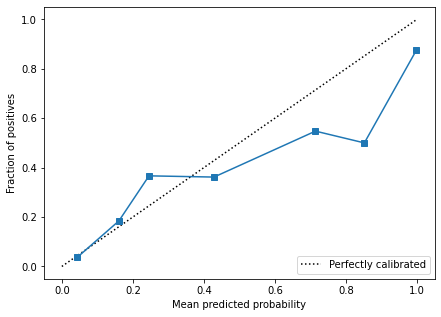

In [40]:
#Calibration Display Diagram for Isotonic: 

from sklearn.calibration import calibration_curve, CalibrationDisplay
plt.rcParams["figure.figsize"] = (7,5)
prob_true_1, prob_pred_1 = calibration_curve(y_binary_test,calibrated_p_iso, n_bins=10)
disp_2 = CalibrationDisplay(prob_true_1, prob_pred_1,calibrated_p_iso )

disp_2.plot()



**Calibration Display Diagram for Platt Scaling **

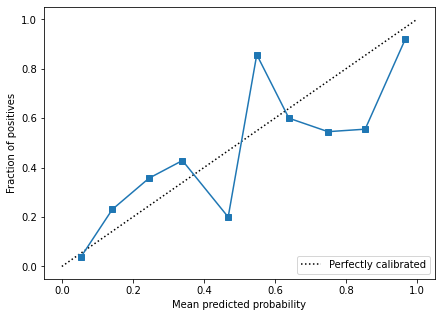

In [41]:
#Calibration Display Diagram for Platt 
plt.rcParams["figure.figsize"] = (7,5)
prob_true_2,prob_pred_2=calibration_curve(y_binary_test,calibrated_p_platt,n_bins=10)
platt_display = CalibrationDisplay(prob_true_2,prob_pred_2,calibrated_p_platt)
platt_display.plot()

**Calibration Display Diagram for Histogram Binning **

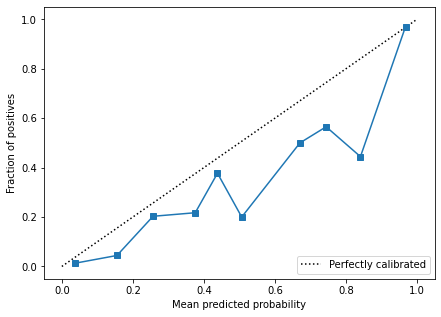

In [42]:
plt.rcParams["figure.figsize"] = (7,5)

prob_true_3, prob_pred_3 = calibration_curve(y_binary_test,calibrated_p_bin, n_bins=10,normalize='True')
disp_3 = CalibrationDisplay(prob_true_3, prob_pred_3,calibrated_p_bin )
disp_3.plot()

**Comparison Plot between Uncalibrated Classifer, Isotonic, Platt and Histogram Binning ** 

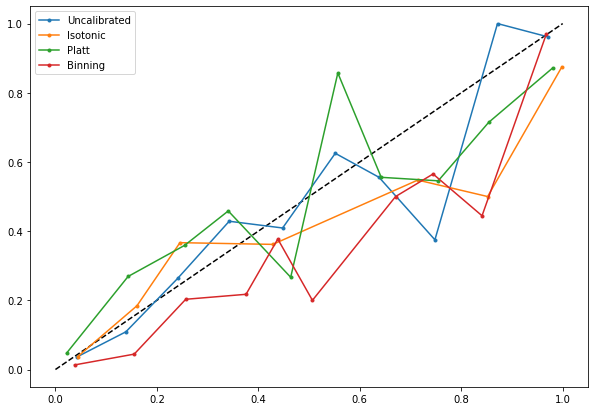

In [43]:
# reliability diagrams
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,7)

p_1, y_1 = calibration_curve( y_binary_test,uncalibrated_p, n_bins=10, normalize=True)
p_2, y_2 = calibration_curve( y_binary_test,calibrated_p_iso, n_bins=10, normalize=True)
p_3, y_3 = calibration_curve(y_binary_test, calibrated_p_platt ,n_bins=10, normalize=True)
p_4, y_4 = calibration_curve( y_binary_test,calibrated_p_bin, n_bins=10, normalize=True)

# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliabilities
plt.plot(y_1, p_1, marker='.',label='Uncalibrated')
plt.plot(y_2, p_2, marker='.',label='Isotonic')
plt.plot(y_3, p_3, marker='.',label='Platt')
plt.plot(y_4, p_4, marker='.',label='Binning')
plt.legend()
plt.show()


https://wttech.blog/blog/2021/a-guide-to-model-calibration/

Platt Scaling code reference

In [ ]:
# from sklearn.linear_model._glm.glm import BaseEstimator
# from sklearn.linear_model import LogisticRegression

# class PlattCalibrator(BaseEstimator):
#   def __init__(self,c:int=1e10):
#     self.c=c
  
#   def fit(self,p:np.ndarray, y :np.ndarray):
#     logistic=LogisticRegression(C=self.c,solver='lbfgs')
#     logistic.fit(p.reshape(-1,1),y)
#     self.coef_=logistic.coef_[0]
#     self.intercept_=logistic.intercept_
#     return self
  
#   def predict_proba(self,p:np.ndarray)->np.ndarray:
#     output=p*self.coef_[0]+self.intercept_
#     output=1/(1+np.exp(-output))
#     return output


# platt= PlattCalibrator(c=1e10)
# platt.fit(uncalibrated_p_valid,y_binary_val)
# platt_probs=platt.predict_proba(uncalibrated_p)


# prob_true,prob_pred=calibration_curve(y_binary_test,platt_probs,n_bins=10)
# platt_display = CalibrationDisplay(prob_true,prob_pred,platt_probs)
# platt_display.plot()

# #platt scaling method 
# from sklearn.linear_model import LinearRegression 
# class PlattScaling:
#     def __init__(self, prob_pred, prob_true):
#         prob_pred, prob_true = self._filter_out_of_domain(prob_pred, prob_true)
#         prob_true = np.log(prob_true / (1 - prob_true))
#         self.regressor = LinearRegression().fit(prob_pred.reshape(-1, 1), prob_true.reshape(-1, 1))

#     def calibrate(self, probabilities): #basically a sigmoid function i guess?
#         return 1 / (1 + np.exp(-self.regressor.predict(probabilities.reshape(-1, 1)).flatten()))

#     def _filter_out_of_domain(self, prob_pred, prob_true):
#         filtered = list(zip(*[p for p in zip(prob_pred, prob_true) if 0 < p[1] < 1]))
#         return np.array(filtered)


# from scipy.optimize import minimize

# class HB_calibrator:

#     def fit(self, p, y):
#         bins = 20
#         self.sorted_p = np.sort(p)
#         self.proba_bins = np.array_split(self.sorted_p, bins)
        
#         fun =  lambda theta: np.sum([np.sum((theta[m] - self.proba_bins[m])**2) for m in range(bins)])
#         self.opt = minimize(fun, x0 = np.zeros(20),method='nelder-mead')      
#         return self

#     def predict_proba(self, p):
#         insert_index = np.searchsorted(self.sorted_p, p,side = 'left')
#         bin_len = len(self.proba_bins[0])
#         bin_index = insert_index // bin_len
#         bin_score = np.take(self.opt.x,bin_index)
#         return p+bin_score


# p = uncalibrated_p
# y = y_binary_test
# bins = 10

# # sorted_index_p = np.argsort(p)
# sorted_p = np.sort(p)
# proba_bins = np.array_split(sorted_p, bins)
# # index_bins = np.array_split(sorted_index_p, bins)

# from scipy.optimize import minimize

# fun =  lambda theta: np.sum([np.sum((theta[m] - proba_bins[m])**2) for m in range(bins)])
# opt = minimize(fun, x0 = np.zeros(10),method='nelder-mead')
# opt.x

# insert_index = np.searchsorted(sorted_p, [sorted_p[200], sorted_p[220]],side = 'left')
# insert_index
# # opt.x[math.floor(insert_index/ 199)], math.floor(insert_index/ 199)
# a = insert_index// len(proba_bins[0])
# [sorted_p[200], sorted_p[220]] +np.take(opt.x, a)
# # opt.x, a

In [ ]:
#// END_TODO [STEP_6]

#### Step 7

Evaluate the performance of your calibration methods. Describe your observations in the variable `observation_calibrators` (max 2000 characters).

In [ ]:
#// BEGIN_TODO [STEP_7] Evaluate the calibration method (10 points)

# ===== =====> Replace this line by your code. <===== ===== #


In [ ]:
#// END_TODO [STEP_7]

#### Step 8

Let's evaluate your selected calibration method on the output from different classifier, stored in the `./data/wafer_calibration.pkl` pickle file.

In [ ]:
with open('./data/wafer_calibration.pkl', 'rb') as f:
    p_calib_train, p_calib_test, y_calib_train, y_calib_test = pickle.load(f)

`p_calib_train` and `p_calib_test` contain the confidence estimates of a classifier (divided into a training and test set), and `y_calib_train` and `y_calib_test` contain the corresponding true labels.

Retrain your calibration methods on `p_calib_train` and `y_calib_train`. Use `p_calib_test` and `y_calib_test` to evaluate your methods. Describe your observations in the variable `observation_other` (max 800 characters).

In [ ]:
#// BEGIN_TODO [STEP_8] Evaluate the calibration method on another classifier (5 points)

# ===== =====> Replace this line by your code. <===== ===== #


In [ ]:
#// END_TODO [STEP_8]

#### Step 9

Choose your favorite calibration method. Assign the instantiated class implementing your chosen calibration method to the variable `binary_calibrator` and its name to a string variable `binary_calibrator_choice`. Motivate the choice (including hyper-parameters, if any) in a string variable `binary_calibrator_motivation` (max 800 characters).

Apply the chosen calibration method to your model on the test data `X_test` and assign the calibrated confidence estimates to `q_test` (an `np.ndarray` of shape $[N,]$ and `dtype` of `np.float32`).

Apply the calibration method to the confidence estimates in `p_calib_test` and assign the calibrated class probabilities to the variable `q_calib_test` (an `np.ndarray` of shape $[N,]$ and `dtype` of `np.float32`).

Measure the calibration error of the calibrated model and assign the result to the variable `binary_calibrated`.

In [ ]:
#// BEGIN_TODO [STEP_9] Choose a calibration method (5 points)

# ===== =====> Replace this line by your code. <===== ===== #


In [ ]:
#// END_TODO [STEP_9]

#### Leaderboard

If you would like to see how your binary calibration method compares to others, you can chose to submit your calibration method to the leaderboard. All submitted calibration methods will be evaluated on a held-out set from a similar distribution as `p_calib_test` and `y_calib_test`.

You may submit your notebook as many times as you like before the deadline. We will try to update the leaderboard daily. Your latest submission at the moment the leaderboard is computed will count. 

If you would like to submit your `binary_calibrator` to the leaderboard, then assign a reference to your *trained* calibration method to the variable `leaderboard_calibrator`. Otherwise, set it to `None`. Since it will be evaluated on a held-out set, you are free to use any data that was included with this assignment. Also, assign a nickname to the string variable `leaderboard_nickname` that will be shown on the leaderboard next to your score.

In [ ]:
#// BEGIN_TODO [LEADERBOARD] Join the leaderboard (0 points)

# ===== =====> Replace this line by your code. <===== ===== #


In [ ]:
#// END_TODO [LEADERBOARD]

## Extend to multi-class classification

So far we have assumed a binary classification task. In this part you will implement a calibration metric and method that is applicable to multi-class classification.

#### Step 10

For evaluating the multi-class calibration metric and method, train a classifier on the multi-class wafer map data `X_train` and `y_train` that was loaded earlier. You are free to chose any model and data preprocessing method, as long as:

- your classifier outputs the predicted class and the confidence estimate for each class,
- your submission executes within 10 minutes on Momotor,
- you use the libraries available on Momotor (if you would like to use other libraries, please contact the instructor to see if it can be accommodated).

Evaluate your trained model on the test set `X_test` and `y_test`. What do you observe? How do you know that your model is well trained? Assign your answer to a string variable `observation_multiclass_classifier` (max 600 characters).

Apply the classifier to the `X_test` data and store the predicted classes and confidence estimates in the variables `multi_uncalibrated_y` and `multi_uncalibrated_p`, respectively:

- `multi_uncalibrated_y` should be a `np.ndarray` of shape $[N,K]$, with the predicted classes (one-hot encoded), where $N$ is the number of samples and $K$ is the number of classes, i.e. `multi_uncalibrated_y[n][k]` is 1 if the classifier predicted class `k`, otherwise it is 0, 
- `multi_uncalibrated_p` should be a `np.ndarray` of shape $[N,K]$, with the corresponding confidence estimates, i.e. `multi_uncalibrated_p[n][k]` is the classifier's confidence that the predicted class should be `k`.

> **IMPORTANT:** For the wafer dataset $K = 9$ and the class indeces should correspond to the classes listed in section **Load the data**.

In [ ]:
#// BEGIN_TODO [STEP_10] Train a multi-class classifier (10 points)
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)

from sklearn.preprocessing import OneHotEncoder as ohe

enc = ohe(categories = [[0,1,2,3,4,5,6,7,8]] , handle_unknown = 'infrequent_if_exist')
encoded_y = enc.fit_transform(y_train.reshape(-1,1)).toarray()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

multi_clf = LogisticRegression(class_weight = 'balanced', )
ovr = OneVsRestClassifier(multi_clf)
ovr.fit(preprocess(X_train), encoded_y)

OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced'))

In [ ]:
multi_uncalibrated_y = ovr.predict(preprocess(X_test))
multi_uncalibrated_p = ovr.predict_proba(preprocess(X_test))

In [ ]:
observation_multiclass_classifier = ""

In [ ]:
#// END_TODO [STEP_10]

#### Step 11

Choose a calibration metric and assign your choice to a string variable `multi_calibration_choice`. Motivate the choice (including the hyper-parameters, if any) in a string variable `multi_calibration_motivation` (max 800 characters). Describe how you decide based on this metric if a classifier is sufficiently calibrated in a string variable `multi_calibration_decision` (max 200 characters).

In [ ]:
#// BEGIN_TODO [STEP_11] Choose a multi-class calibration metric (5 points)

multi_calibration_choice = ""

multi_calibration_motivation = ""

multi_calibration_decision = ""

In [ ]:
#// END_TODO [STEP_11]

#### Step 12

Implement the chosen calibration metric. It should be a Python class with the following method:

- `score(self, p, y)`, where
    - `p` is a `np.ndarray` of shape $[N,K]$ with the confidence estimates, where $N$ is the number of samples and $K$ is the number of classes,
    - `y` is a `np.ndarray` of shape $[N,K]$ with the corresponding true class labels (one-hot encoded)
    - It returns a `np.float` number with the calibration error.

Instantiate the class (setting any relevant hyper-parameters) and assign it to the variable `multi_metric`.

Measure the calibration error of your model on `X_test` and `y_test` and assign the result to the variable `multi_uncalibrated`.

In [ ]:
#// BEGIN_TODO [STEP_12] Implement the multi-class calibration metric (5 points)

# ===== =====> Replace this line by your code. <===== ===== #


In [ ]:
#// END_TODO [STEP_12]

#### Step 13

Implement at least one calibration method. Each calibration method should be a Python class with the following methods:

- `fit(self, p, labels)`: where 
    - `p` is a `np.ndarray` of shape $[N,K]$ with the confidence estimates, where $N$ is the number of samples and $K$ is the number of classes,
    - `y` is a `np.ndarray` of shape $[N,K]$ with the corresponding true class labels (one-hot encoded)
    - It fits the calibration model and returns a reference to `self`.

- `predict_proba(self, p)`: where
    - `p` is a `np.ndarray` of shape $[N,K]$ with the confidence estimates, where $N$ is the number of samples and $K$ is the number of classes,
    - It returns an `np.ndarray` of shape $[N,K]$ with the calibrated confidence estimates for each sample in `p`.

> **IMPORTANT:** You are not allowed to use the `sklearn.calibration.CalibratedClassifierCV()` method.

Instantiate the calibration methods (setting any relevant hyper-parameters) and assign them to a list variable `multi_calibrators`.

In [ ]:
#// BEGIN_TODO [STEP_13] Implement multi-class calibration methods (10 points)

# ===== =====> Replace this line by your code. <===== ===== #


In [ ]:
#// END_TODO [STEP_13]

#### Step 14

Evaluate the performance of your calibration methods. Choose your favorite method and assign its name to a string variable `multiclass_calibrator_choice`. Motivate the choice (including hyper-parameters, if any) in a string variable `multiclass_calibrator_motivation` (max 800 characters).

Apply the chosen calibration method to your model on the test data `X_test` and assign the calibrated confidence estimates to `q_multi_test` (an `np.ndarray` of shape $[N,K]$ and `dtype` of `np.float32`).

Measure the calibration error of the calibrated model and assign the result to the variable `multi_calibrated`.

In [ ]:
#// BEGIN_TODO [STEP_14] Choose a multi-class calibration method (5 points)

# ===== =====> Replace this line by your code. <===== ===== #


In [ ]:
#// END_TODO [STEP_14]

#### Step 15

A well calibrated classifier can also be used to identify whether a test sample is out-of-distribution, i.e. if it is very different from the data that the classifier was trained on. The `ood.pkl` file contains several out-of-distribution samples.

In [ ]:
with open('./data/ood.pkl', 'rb') as f:
    X_ood = pickle.load(f)
    
plt.imshow(X_ood[0]);

Evaluate your classifier and calibration method on the data in `X_ood`. Describe your observations in a string variable `observation_ood` (max 1000 characters). Describe one drawback of this approach for identifying out-of-distribution samples in a string variable `drawback_ood` (max 500 characters).

In [ ]:
#// BEGIN_TODO [STEP_15] (5 points)

# ===== =====> Replace this line by your code. <===== ===== #


In [ ]:
#// END_TODO [STEP_15]

# Feedback

Please fill in this questionaire to help us improve this course for the next year. Your feedback will be anonymized and will not affect your grade in any way!

### How many hours did you spend on this assignment?

Assign a number to variable `feedback_time`.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_1] (0 points)

#// END_FEEDBACK [Feedback_1]

import numbers
assert isinstance(feedback_time, numbers.Number), "Please assign a number to variable feedback_time"

### How difficult did you find this assignment?

Assign an integer to variable `feedback_difficulty`, on a scale 0 - 10, with 0 being very easy, 5 being just right, and 10 being very difficult.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_2] (0 points)

#// END_FEEDBACK [Feedback_2]

assert isinstance(feedback_difficulty, numbers.Number), "Please assign a number to variable feedback_difficulty"

### Which Machine Learning-related courses did you complete (TUE/workshop/online/etc.)?

Assign a string to variable `feedback_courses`, listing any ML courses you followed.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_3] (0 points)

#// END_FEEDBACK [Feedback_3]

assert isinstance(feedback_courses, str), "Please assign a string to variable feedback_courses"

### Would you prefer to earn points for the leaderboard exercise?

Currently, the leaderboard exercise is optional: your participation on the leaderboard does not affect your grade, neither does your position on the leaderboard. Would you enjoy a leaderboard exercise, where each group's score is published on the leaderboard and the winning group gets a reward (e.g. they get a 10 for the entire assignment, all other groups are assessed normally on the other exercises)?

Assign a number to variable `feedback_leaderboard`:

- 1 for "yes, I would like it"
- 0 for "I do not have an opinion"
- -1 for "no, I prefer an optional leaderboard"

In [ ]:
#// BEGIN_FEEDBACK [Feedback_4] (0 points)

#// END_FEEDBACK [Feedback_4]

assert isinstance(feedback_leaderboard, numbers.Number), "Please assign a number to variable feedback_leaderboard"

### (Optional) What did you like?

Assign a string to variable `feedback_like`.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_5] (0 points)

#// END_FEEDBACK [Feedback_5]

### (Optional) What can be improved?

Assign a string to variable `feedback_improve`. Please be specific, so that we can act on your feedback.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_6] (0 points)

#// END_FEEDBACK [Feedback_6]